# **의도 분류(Multi-Kernel-CNN)**
## 참고 URL:
- 데이터 처리: https://velog.io/@yelim421/Multi-Kernel-1D-CNN
- 모델: https://derekahndev.github.io/machine%20learning/chatbot-4/
- 결과 시각화: https://codetorial.net/tensorflow/visualize_training_history.html

## **1. 환경설정**

★★★★★★★★★★ 필수! ★★★★★★★★★★

아래 셀 실행 후 **런타임 다시 시작**을 해야 적용이 됨

★★★★★★★★★★★★★★★★★★★★★★★

In [1]:
!pip install konlpy
!pip uninstall tensorflow
!pip install tensorflow==1.15
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 55.4 MB/s 
Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220719082949.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████████████

In [1]:
import tensorflow as tf
print('1.15.0로 나와야 버전 적용이 된 것입니다.')
tf.__version__

1.15.0로 나와야 버전 적용이 된 것입니다.


'1.15.0'

In [2]:
import json
with open('dongwon_intent.json', 'r', encoding='utf-8') as f:
    intent_json = json.load(f)
import pandas as pd
from konlpy.tag import Okt
okt=Okt()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import urllib.request
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

## **2. 데이터 전처리**

In [49]:
intents = intent_json['intents']

In [50]:
label_list = []
itt_list = []

intents = intent_json['intents']
for i, intent in enumerate(intents):
    for j in range(len(intent['examples'])):
        label_list.append(intent['intent'])
        itt_list.append(intent['examples'][j]['text'])

df = pd.DataFrame((zip(itt_list, label_list)), columns = ['intent', 'label'])
# df.sample(frac=1)

# df['label'].value_counts()

train, test셋을 나누기 위해서는 label별 데이터가 2개 이상 있어야 하지만

label이 '정보성질문'인 데이터의 개수가 1개임...

intent을 추가할 수 있지만 일단 해당 컬럼을 삭제하여 진행

In [51]:
new_df=df.drop(df[df['label']=='정보성질문'].index).reset_index(drop=True)

intent_train, intent_test, label_train, label_test = train_test_split(new_df['intent'],new_df['label'],test_size=0.3, stratify = new_df['label'])

# y_train,y_valid 비율 확인 (value_counts())
# print(label_train.value_counts())
# print(label_test.value_counts())

In [52]:
# Series(intent+label)를 합쳐 Dataframe으로
train_data = pd.concat([intent_train, label_train], axis=1)
test_data = pd.concat([intent_test, label_test], axis=1)

In [53]:
print('고유값들의 수(intent, label):', train_data['intent'].nunique(), train_data['label'].nunique())
train_data.drop_duplicates(subset=['intent'], inplace=True)
print('총 샘플의 수:', len(train_data))
print('Null값 존재 확인:', train_data.isnull().values.any())

고유값들의 수(intent, label): 15324 415
총 샘플의 수: 15324
Null값 존재 확인: False


## **3. 토큰화**

In [54]:
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = []
X_train_token = []
for sentence in train_data['intent']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train_token.append(temp_X)

X_test_token = []
for sentence in test_data['intent']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test_token.append(temp_X)

In [55]:
print(train_data)
print(X_train_token[0], len(X_train_token[0]))

                                intent       label
16517                동원몰 고객만족센터 연락처 질문   고객만족센터연락처
1414                                어네         쓰레기
21677                     mg에 대해 문의합니당          mg
20872   비타민 B복합체는 어떠한 좋은점이 있는지 안내 부탁해요     비타민B복합체
4387                   해줄 수 있는게 뭐가 있지?        챗봇역할
...                                ...         ...
18207          동원 몰에서 가장 인기 있는 상품이 뭐야?  동원몰베스트상품소개
11697  비회원 구매로 주문했는데 배송 확인 어떻게 하는지 알려줘     비회원배송확인
4354                  제공 서비스에 대해 말해주세요        챗봇역할
10466               쿠폰으로 결제 어떻게 하는건가요?      쿠폰결제안내
3160                        배송 정책 설명해줘        배송정책

[15324 rows x 2 columns]
['동원', '몰다', '고객', '만족', '센터', '연락처', '질문'] 7


## **4. 정수 인코딩**

In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_token)

# tokenizer.word_index

# 불용어 사전 등록을 위해 단어 빈도수 체크
word_count_dic = list(sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True))[:100]
# word_count_dic

In [57]:
# 등장 빈도수가 3회 미만인 단어들의 비중 확인
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('vocabulary 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print("단어 집합에서 희귀 단어의 비율:", (rare_freq / total_freq)*100)

vocabulary 크기 : 2835
등장 빈도가 2번 이하인 희귀 단어 수: 1466
단어 집합에서 희귀 단어의 비율: 51.71075837742505
단어 집합에서 희귀 단어의 비율: 1.8489011814929501


In [58]:
# e
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 1370


In [59]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_token)
X_train = tokenizer.texts_to_sequences(X_train_token)
X_test = tokenizer.texts_to_sequences(X_test_token)

print(X_train[:3])

[[21, 34, 141, 329, 151, 411, 47], [1176, 479], [205, 8, 37, 225, 395, 396]]


In [60]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [61]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

15137
15137


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [62]:
# 레이블 인코딩. 레이블에 고유한 정수를 부여
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(y_train)

y_train = idx_encode.transform(y_train) # 주어진 고유한 정수로 변환
y_test = idx_encode.transform(y_test) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print('레이블과 정수의 맵핑 관계 :',label_idx)

# 추론에 쓰일 Dict
reverse_label_idx = {v:k for k,v in label_idx.items()} #// {'AA': '0', 'BB': '1', 'CC': '2'}

레이블과 정수의 맵핑 관계 : {'10주년이벤트안내': 0, '10주년쿠폰유효기간': 1, '10주년쿠폰적용범위': 2, '10주년쿠폰할인금액': 3, '10주년타임특가상품': 4, '10주년타임특가시간': 5, '17년11월롯데리아행사': 6, '17년11월판촉': 7, '17년12월판촉': 8, '18년1월셀렉토커피행사': 9, '18년1월판촉': 10, 'GNC골드회원가입': 11, 'GNC골드회원갱신': 12, 'GNC골드회원안내': 13, 'GNC골드회원이용': 14, 'GNC골드회원인증': 15, 'GNC골드회원혜택': 16, 'GNC상품추천': 17, 'GNC선물세트': 18, 'GNC선물세트특판': 19, 'IU': 20, 'VIP등급기준안내': 21, 'VIP등급회원혜택': 22, 'mcg': 23, 'mg': 24, 'price_present_b1': 25, 'price_present_b3': 26, 'price_present_b5': 27, 'price_present_o5': 28, '가공선물세트': 29, '가공선물세트특판': 30, '가공유지장류': 31, '감사': 32, '거절': 33, '건강선물세트특판': 34, '건강식품선물세트': 35, '결제방법변경': 36, '결제방법안내': 37, '결제지연경우안내': 38, '고객기분나쁨': 39, '고객기분좋음': 40, '고객만족센터연락처': 41, '고객만족센터운영시간': 42, '고객만족센터전화불통': 43, '고등어레시피': 44, '골드등급기준안내': 45, '골드등급회원혜택': 46, '공인인증서의무사용안내': 47, '곶감견과버섯세트': 48, '과일사과배세트': 49, '교양없는호출': 50, '교환신청방법안내': 51, '교환요청': 52, '교환절차': 53, '교환정책': 54, '교환회수날짜지정': 55, '굴비옥돔수산세트': 56, '그린등급회원혜택': 57, '그만': 58, '기분질문': 59, '기프티모아_선물세트': 60, '기획전보러가기': 61, '김

리뷰의 최대 길이 :  65
리뷰의 평균 길이 :  6.470502741626478


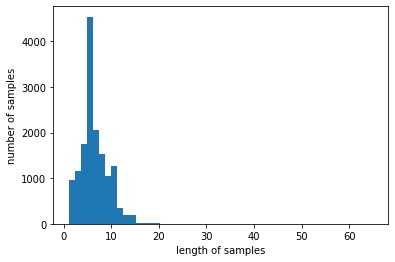

In [63]:
print('리뷰의 최대 길이 : ',max(len(l) for l in X_train))
print('리뷰의 평균 길이 : ',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [64]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [65]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 100.0


## **5. 패딩**

In [66]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

print(X_train.shape)
print(X_test.shape)

(15137, 70)
(6582, 70)


## **6. D1 CNN 모델 학습 및 평가**

In [67]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [68]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size  # 전체 단어 수

# CNN 모델 정의
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=max_len)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

conv1 = Conv1D(
    filters=128,
    kernel_size=3,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPooling1D()(conv1)

conv2 = Conv1D(
    filters=128,
    kernel_size=4,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPooling1D()(conv2)

conv3 = Conv1D(
    filters=128,
    kernel_size=5,
    padding='valid',
    activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPooling1D()(conv3)

# 3, 4, 5-gram 이후 합치기
concat = Concatenate()([pool1, pool2, pool3]) # Concatenate([pool1, pool2, pool3])에서 수정

hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
# predictions = Dense(5, activation=tf.nn.softmax)(logits)
predictions = Dense(415, activation=tf.nn.softmax)(logits)

# 모델 생성
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
cnn_model = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=EPOCH, verbose=1)

# # 모델 평가(테스트 데이터셋 이용)
# loss, accuracy = model.evaluate(test_ds, verbose=1)
# print('Accuracy: %f' % (accuracy * 100))
# print('loss: %f' % (loss))

# # 모델 저장
# model.save('intent_model.h5')

Train on 15137 samples, validate on 6582 samples
Epoch 1/30
15137/15137 [==============================] - 3s 219us/sample - loss: 5.1134 - acc: 0.0465 - val_loss: 3.7532 - val_acc: 0.2091
Epoch 2/30
15137/15137 [==============================] - 2s 162us/sample - loss: 3.2552 - acc: 0.2790 - val_loss: 2.3318 - val_acc: 0.5387
Epoch 3/30
15137/15137 [==============================] - 2s 162us/sample - loss: 2.4740 - acc: 0.4060 - val_loss: 1.8810 - val_acc: 0.5998
Epoch 4/30
15137/15137 [==============================] - 3s 214us/sample - loss: 2.1426 - acc: 0.4620 - val_loss: 1.6731 - val_acc: 0.6284
Epoch 5/30
15137/15137 [==============================] - 2s 161us/sample - loss: 1.9563 - acc: 0.4971 - val_loss: 1.5235 - val_acc: 0.6664
Epoch 6/30
15137/15137 [==============================] - 2s 162us/sample - loss: 1.8238 - acc: 0.5157 - val_loss: 1.4370 - val_acc: 0.6946
Epoch 7/30
15137/15137 [==============================] - 3s 191us/sample - loss: 1.7399 - acc: 0.5333 - val_lo

{'loss': [5.113350546910503, 3.255196859399181, 2.4739577889781086, 2.1425959273248414, 1.9563167748563377, 1.823773147676, 1.7399399239281221, 1.6586620423971352, 1.6163179445764446, 1.5589796880706421, 1.5226009953755986, 1.4632986947867517, 1.4400555037708715, 1.4297703295955226, 1.3831702191007336, 1.362600437304992, 1.3437180296073874, 1.2861247182330708, 1.2605478805162211, 1.2481640544098271, 1.229623631236496, 1.195729522902907, 1.185643720321267, 1.149336746585269, 1.1321282849772065, 1.0997367945310894, 1.096304606216354, 1.0715923579273745, 1.0523109745352712, 1.0372573287396871], 'acc': [0.046508554, 0.27898526, 0.40595892, 0.46198058, 0.49706018, 0.51569, 0.53332895, 0.5505054, 0.56140584, 0.56959766, 0.5764682, 0.59199315, 0.5941732, 0.5988637, 0.61049086, 0.61405826, 0.6131995, 0.6348682, 0.6417388, 0.6423333, 0.64722204, 0.6577261, 0.65950984, 0.664927, 0.67100483, 0.6789324, 0.6814428, 0.6883134, 0.69439125, 0.695184], 'val_loss': [3.753212496488879, 2.331808750624354,

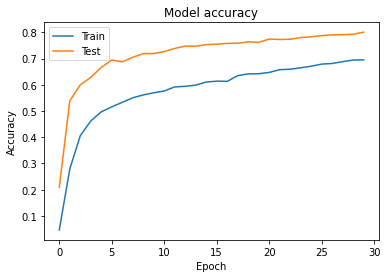

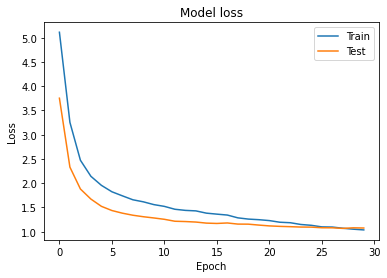

In [88]:
print(cnn_model.history)

# 훈련 과정 시각화 (정확도)
plt.plot(cnn_model.history['acc'])
plt.plot(cnn_model.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 훈련 과정 시각화 (손실)
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [26]:
# 모델 평가(테스트 데이터셋 이용)
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

# 모델 저장
model.save('cnn_model_1.h5')

6582/6582 [==============================] - 1s 106us/sample - loss: 1.0073 - acc: 0.7946
Accuracy: 79.459131
loss: 1.007330


In [76]:
def intentClassification(text):
    new_sentence = okt.morphs(text, stem=True)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = model.predict(pad_new)

    return reverse_label_idx.get(np.argmax(score))

In [87]:
intentClassification(input())

비번 까먹었는데 어떻게 해야하나요?


'회원비밀번호분실'

# **★ 이 아래부터는 실행 안해도 됨! ★**

In [ ]:
# embedding_dim = 128
# dropout_prob = (0.5,0.8)
# num_filters = 128

# model_input = Input(shape = (max_len,))
# z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
# z = Dropout(dropout_prob[0])(z)

# conv_blocks = []

# for sz in [3,4,5]:
#     conv = Conv1D(filters = num_filters,
#                   kernel_size = sz,
#                   padding = "valid",
#                   activation = "relu",
#                   strides = 1)(z)
#     conv = GlobalMaxPooling1D()(conv)
#     conv = Flatten()(conv)
#     conv_blocks.append(conv)

# z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
# z = Dropout(dropout_prob[1])(z)
# z = Dense(128, activation="relu")(z)
# model_output = Dense(1, activation="sigmoid")(z)

# model = Model(model_input, model_output)
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_data = (X_test, y_test), verbose=2, callbacks=[es, mc])

In [ ]:
# loaded_model = load_model('CNN_model.h5')
# print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
# def sentiment_predict(new_sentence):
#     new_sentence = okt.morphs(new_sentence, stem=True)
#     new_sentence = [word for word in new_sentence if not word in stopwords]
#     encoded = tokenizer.texts_to_sequences([new_sentence])
#     pad_new = pad_sequences(encoded, maxlen = max_len)
#     score = float(model.predict(pad_new))
#     if(score > 0.5):
#         print("{:.2f}% 확률로 긍정 리뷰이다.\n".format(score * 100))
#     else:
#         print("{:.2f}% 확률로 부정 리뷰이다.\n".format((1 - score) * 100))

In [ ]:
# sentiment_predict('상품 주문 좀 하고싶어!')

100.00% 확률로 긍정 리뷰이다.

